In [118]:
import xnet
import json
import glob

import numpy as np
import matplotlib.pyplot as plt

from igraph import *
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
from util import save,load
from util import get_attr_pacs,get_pac_list,get_pacs_paper_published

In [119]:
attr_pacs = get_attr_pacs()
pac_list = get_pac_list()

In [120]:
def get_in(paper,data):
    pacs = []
    p_neighbors = data.neighbors(paper,mode=IN)
    n_neighbors = len(p_neighbors)
    return n_neighbors

def get_out(paper,data):
    pacs = []
    p_neighbors = data.neighbors(paper,mode=OUT)
    n_neighbors = len(p_neighbors)
    return n_neighbors

In [121]:
def get_freq_of(data,get_freq,delta,filename):

	history = defaultdict(lambda:defaultdict(lambda:0))

	year_begin = 1986
	year_end = 2006

	for i,year in enumerate(range(year_begin,year_end+1)):
		print("current year %d" % year)
		subset = data.vs.select(year_ge=year,year_le=year+delta)
		subgraph = data.subgraph(subset)
		for paper in subgraph.vs:
			authors_idxs = paper['authors_idxs'].split(',')
			value = get_freq(paper,subgraph)
			for author in authors_idxs:
				history[author][year+delta] += value
		save(history,filename)

	return history

In [109]:
data = xnet.xnet2igraph('data/citation_network_ge1985_pacs.xnet')

filenames = sorted(glob.glob('data/pacs/2lvls/*_multilevel2.xnet'))
pac_nets = []
for filename in filenames:
	net = xnet.xnet2igraph(filename)
	pac_nets.append(net)

In [144]:
def plot_freq_publications(data,delta):
    year_begin = 1986
    year_end = 2006

    X = []
    Y = []
    for i,year in enumerate(range(year_begin,year_end+1)):
        print("current year %d" % year)
        subset = data.vs.select(year_ge=year,year_le=year+delta)
        subgraph = data.subgraph(subset)
        X.append(int(year+delta))
        Y.append(subgraph.vcount())
    
    fig = plt.figure(figsize=(12,3))
    plt.plot(X,Y,marker='o')

current year 1986
current year 1987
current year 1988
current year 1989
current year 1990
current year 1991
current year 1992
current year 1993
current year 1994
current year 1995
current year 1996
current year 1997
current year 1998
current year 1999
current year 2000
current year 2001
current year 2002
current year 2003
current year 2004
current year 2005
current year 2006


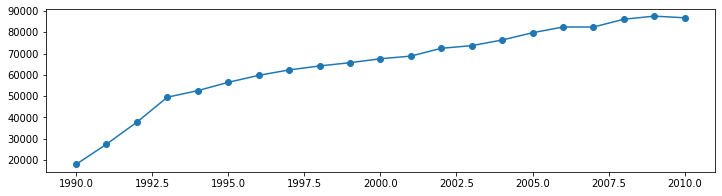

In [145]:
plot_freq_publications(data,4)
# get_freq_of(data,get_in,1,'authors_in_freq2.json') 2 é de delta 2 (1 + inclusivo)
# get_freq_of(data,get_in,4,'authors_in_freq_temp.json')

In [7]:
# get_freq_of(data,get_out,1,'authors_out_freq2.json') 2 é de delta 2 (1 + inclusivo)

In [110]:
'''
    essa função diz a quantidade de autores por ano,
    sem fazer rastreio para que seja os mesmos autores
'''
def get_min_freqs(data,min_values):
    freq = defaultdict(lambda:[])
    for author,a_hist in data.items():
        for year,value in a_hist.items():
            freq[year].append(value)
    
    years = []
    freqs_dict = {}
    for min_value in min_values:
        freqs_dict[min_value] = []
    
    for year,freqs in freq.items():
        years.append(year)
        freqs = np.asarray(freqs)
        total = len(freqs)
        
#         print('total',total)
        
        for min_value in min_values:
#             print(sum(freqs >= min_value))
            p = sum(freqs >= min_value)
            freqs_dict[min_value].append(p)

        return years,freqs_dict

In [157]:
'''
    essa função diz a quantidade de autores por ano
    e faz rastreio para que seja os mesmos autores
'''
def get_min_freqs_author_track(data,min_values):
    authors_by_min = dict()
    for min_value in min_values:
        freq = defaultdict(lambda:[])
        freq_all_authors = defaultdict(lambda:0)
        last_year = set(data.keys())
        for author,a_hist in data.items():
            for year,value in a_hist.items():
                freq_all_authors[year] += 1
                if int(year) < 1995: # ignora tudo que acontece antes de 2000
                    continue
                if value < min_value:
                    last_year.discard(author)
                else:
                    freq[author].append(int(year))
#         x = list(freq_all_authors.keys())
#         y = list(freq_all_authors.values())
#         plt.plot(x,y)

        valids = []
        for author,years in freq.items():
            if author not in last_year: # last_year começa com todos os autores e remove os com menos do que o min
                continue
            min_year = min(years)
            max_year = max(years)
            seq_years = set(range(min_year,max_year+1))
            inter = set(seq_years).intersection(years) # garante a sequencia sem furos
            if len(inter) == len(seq_years) and 1995 in seq_years and 2010 in seq_years: # entre 2000 e 2010
                valids.append(author)
        authors_by_min[min_value] = valids
        print(len(valids))
    return authors_by_min

In [171]:
'''
    seleção de autores por critério frouxo
    min 10 pontos que não sejam 0 citações ou referências
'''
def get_select_author_min_criteria(data,min_non_zero=10,min_v=1):
    valid = set()
    
    for author,a_hist in data.items():
        number_of_non_zero = 0
        for year,value in a_hist.items():
            if int(year) < 1995: # ignora tudo que acontece antes de 2000
                continue
            if value >= min_v:
                number_of_non_zero += 1
            
        if number_of_non_zero >= min_non_zero and '1995' in a_hist and '2010' in a_hist:
            valid.add(author)

    return valid

In [112]:
def plot_min_values(years,freqs_dict,title):
    plt.figure(figsize=(10,3))
    for min_value,freqs in freqs_dict.items():
        plt.plot(years,freqs,marker='o',ls='-',label=min_value)
    plt.legend()
    plt.xlabel('year')
    plt.xticks(rotation=45)
    #plt.ylabel('%')
    plt.title(title)
    #plt.ylim((0, 15))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temp/%s.pdf' % title)
    plt.show()

In [147]:
get_freq_of(data,get_in,4,'data/authors_in_freq.json')
get_freq_of(data,get_out,4,'data/authors_out_freq.json')
authors_out = load('data/authors_out_freq.json')
authors_in = load('data/authors_in_freq.json')

current year 1986
current year 1987
current year 1988
current year 1989
current year 1990
current year 1991
current year 1992
current year 1993
current year 1994
current year 1995
current year 1996
current year 1997
current year 1998
current year 1999
current year 2000
current year 2001
current year 2002
current year 2003
current year 2004
current year 2005
current year 2006
current year 1986
current year 1987
current year 1988
current year 1989
current year 1990
current year 1991
current year 1992
current year 1993
current year 1994
current year 1995
current year 1996
current year 1997
current year 1998
current year 1999
current year 2000
current year 2001
current year 2002
current year 2003
current year 2004
current year 2005
current year 2006


In [166]:
min_values = [10,25,50,75,100]
authors_valid_out = get_min_freqs_author_track(authors_out,min_values)
authors_valid_in = get_min_freqs_author_track(authors_in,min_values)

2200
808
315
127
42


In [170]:
for min_value in min_values:
    inter = set(authors_valid_in[min_value]) & set(authors_valid_out[min_value])
    print(min_value,len(inter))

10 1554
25 622
50 242
75 103
100 37


In [174]:
'''
são os autores do critério frouxo considerando a combinação do in e out
'''
for min_v,non_zero in [(1,10),(10,16),(25,16),(50,16)]:
    authors_in_min_criteria = get_select_author_min_criteria(authors_in,non_zero,min_v)
    authors_out_min_criteria = get_select_author_min_criteria(authors_out,non_zero,min_v)
    valid_authors_min_in_out = authors_out_min_criteria & authors_in_min_criteria
    print(len(valid_authors_min_in_out))
    file_to_save = open('valid_authors_min_criteria_in_out_%d_%d.txt'%(min_v,non_zero),'w')
    for author in valid_authors_min_in_out:
        file_to_save.write(author+'\n')
    file_to_save.close()

13733
1554
622
242


In [12]:
def get_total_of(data,get_out,filename):
    freqs = defaultdict(lambda:0)
    for paper in data.vs:
        authors_idxs = paper['authors_idxs'].split(',')
        value = get_out(paper,data)
        for author in authors_idxs:
            freqs[author] += value
    save(freqs,filename)
    return freqs

In [13]:
# get_total_of(data,get_out,'num_of_refs.json')
# get_total_of(data,get_in,'num_of_citations.json')

In [14]:
def get_ranking_by_year(authors_in,years,min_value,k):
    ranking_by_year = dict()
    for year in years:
        ranking = []
        for a, a_hist in authors_in.items():
            if year in a_hist:
                count = a_hist[year]
                ranking.append((count,a))

        if k > 0:
            ranking = sorted(ranking,reverse=True)
            ranking = ranking[:k]
            authors = [a for count,a in ranking]
        else:
            authors = []
            for c,a in ranking:
                if c >= min_value:
                    authors.append(a)

        print(len(authors)*100/len(ranking))
        ranking_by_year[year] = authors
    return ranking_by_year

In [15]:
years = ['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']
ranking_in_by_year = get_ranking_by_year(authors_in,years,25,500)

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0


In [17]:
save(ranking_in_by_year,'data/authors_in_ranking500_by_year.json')

In [27]:
ranking_out_by_year = get_ranking_by_year(authors_out,years,25)

0.7105672201524759
2.1377117502290406
3.5731181299568666
5.230738385109772
5.293186084804246
5.596433855018298
6.028792586736288
6.0444089881664675
6.3810423284966085
6.802257605961964
6.878468048672056
6.854828932373124
8.079488626262782
8.40674071237074
9.566419430117277
10.718111300421995
10.797212283117979
10.989221951018841
11.305434925648111
11.13466843772351
11.181058322716963


In [36]:
# save(ranking_by_year,'authors_out_ranking1000_by_year.json')

In [33]:
ranking_by_year = dict()
for year,ranking_in in ranking_in_by_year.items():
    ranking_in = set(ranking_in)
    ranking_out = set(ranking_out_by_year[year])
    ranking = ranking_in & ranking_out
    ranking_by_year[year] = list(ranking)

In [34]:
save(ranking_by_year,'authors_ranking_min25_by_year.json')

{'2147481374': {'1990': 0,
  '1991': 0,
  '1992': 0,
  '1993': 6,
  '1994': 4,
  '1995': 2,
  '1996': 1,
  '1997': 0,
  '1998': 6,
  '1999': 11,
  '2000': 13,
  '2001': 53,
  '2002': 98,
  '2003': 80,
  '2004': 74,
  '2005': 66,
  '2006': 43,
  '2007': 37,
  '2008': 41,
  '2009': 36,
  '2010': 13},
 '2156212925': {'1990': 12, '1991': 12, '1992': 12, '1993': 12, '1994': 2},
 '2028685499': {'1990': 16,
  '1991': 28,
  '1992': 62,
  '1993': 70,
  '1994': 80,
  '1995': 65,
  '1996': 40,
  '1997': 17,
  '1998': 17,
  '1999': 23,
  '2000': 36,
  '2001': 28,
  '2002': 24,
  '2003': 14,
  '2004': 7,
  '2005': 6,
  '2006': 6,
  '2007': 8,
  '2008': 8,
  '2009': 6,
  '2010': 2},
 '2682499677': {'1990': 0, '1991': 0, '1992': 0, '1993': 0},
 '2720942211': {'1990': 0, '1991': 0, '1992': 0, '1993': 0},
 '2146735552': {'1990': 5,
  '1991': 17,
  '1992': 24,
  '1993': 45,
  '1994': 57,
  '1995': 48,
  '1996': 49,
  '1997': 27,
  '1998': 22,
  '1999': 15,
  '2000': 10,
  '2001': 6,
  '2002': 11,
  '200

In [15]:
pacs_by_year = defaultdict(lambda:[])
for paper in data.vs:
    p0,p1,p2,p3,p4 = paper['PACS-0'],paper['PACS-1'],paper['PACS-2'],paper['PACS-3'],paper['PACS-4']
    year = paper['year']
    pacs_by_year[year].append(p0[:2])
    pacs_by_year[year].append(p1[:2])
    pacs_by_year[year].append(p2[:2])
    pacs_by_year[year].append(p3[:2])
    pacs_by_year[year].append(p4[:2])

for year,pacs in pacs_by_year.items():
    p,c = np.unique(pacs,return_counts=True)
    print(p,c)

[' 6' ' 8' '"6' '+j' '-d' '-h' '01' '02' '03' '04' '05' '06' '07' '11'
 '12' '13' '14' '21' '22' '23' '24' '25' '26' '27' '28' '29' '31' '32'
 '33' '34' '36' '39' '41' '42' '43' '44' '46' '47' '51' '52' '61' '62'
 '63' '64' '65' '66' '67' '68' '71' '72' '73' '74' '75' '76' '77' '78'
 '79' '7l' '81' '82' '83' '84' '85' '87' '89' '91' '92' '94' '95' '96'
 '97' '98' '99' 'Fd' 'No' 'a6' 'b7' 'e2' 'f2' 'll' 'v8' 'x6'] [    1     1     1     1     1     1    10   509  1187   993  2160    26
   137  1489  1515  1178   770   861     1   263   420   775   108   390
     6   120   423   877   296   609   261    26   216  1573    44    35
   128   843    67   795  2008   265   376  1131    69   176   226  1206
  2300   819  1870  1999  2312   309   195  1392   350     1   447   651
   188    49   116   437   112    21    20    13   192    52   149   465
   184     1 28805     1     1     1     1     1     1     1]
[' 0' ' 3' ' 4' ' 6' ' 7' '" ' '01' '02' '03' '04' '05' '06' '07' '11'
 '12' '13' '

['01' '02' '03' '04' '05' '06' '07' '11' '12' '13' '14' '21' '23' '24'
 '25' '26' '27' '28' '29' '31' '32' '33' '34' '36' '37' '41' '42' '43'
 '44' '45' '46' '47' '51' '52' '61' '62' '63' '64' '65' '66' '67' '68'
 '71' '72' '73' '74' '75' '76' '77' '78' '79' '81' '82' '83' '84' '85'
 '87' '89' '91' '92' '93' '94' '95' '96' '97' '98' '99' 'No'] [   64   764  3174  1354  2727    73   198  1550  1687  1037   955   930
   298   404   805   166   386    24   221   575   690   338   549   170
   323   434  2900    79    68   218   144  1247    58  1004  1863   445
   407  1067   151   176   442  1492  3275  1199  2886  2659  3466   373
   433  1786   309   805   778   272    99   545  1246   588    68    37
     2    47   584    78   137   901   341 34294]
['01' '02' '03' '04' '05' '06' '07' '11' '12' '13' '14' '21' '23' '24'
 '25' '26' '27' '28' '29' '31' '32' '33' '34' '36' '37' '41' '42' '43'
 '44' '45' '46' '47' '51' '52' '61' '62' '63' '64' '65' '66' '67' '68'
 '71' '72' '73' '74' '75' 

In [20]:
for pacs in pac_nets[-1:]:
    for v in pacs.vs:
        print(v['community'],v['name'])

1 78
1 79
8 06
9 11
8 37
2 45
4 41
1 71
9 14
3 01
1 85
2 05
8 33
7 95
4 29
6 88
8 32
10 21
2 44
8 36
8 34
8 67
8 07
2 47
4 84
10 28
6 81
10 25
2 02
2 91
2 89
6 43
6 64
7 97
2 93
2 82
6 65
2 51
8 42
6 62
4 94
1 76
2 87
1 73
5 74
2 83
6 61
8 31
7 98
10 23
6 63
6 77
8 03
9 12
6 68
7 96
7 04
4 52
1 72
6 66
6 46
9 13
10 24
10 27
10 26
1 75
2 92
